In [100]:
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
from keras import backend as K
import glob


In [101]:
def min_max_normalization(new_X_array):
    new_x= np.zeros(new_X_array.shape)

    for i in range(new_X_array.shape[2]):
        
        min_val = new_X_array[0][0][i]
        max_val= new_X_array[0][0][i]
        for array in new_X_array:
            for item in array:
                if item[i] < min_val:
                    min_val = item[i]
                if item[i] > max_val:
                    max_val = item[i]

        for j, array in enumerate(new_X_array):
            for k, item in enumerate(array):
                new_x[j][k][i] = (item[i] - min_val) / (max_val - min_val)
                #x_test[j][k][i] = item[i]
    
    return new_x

In [102]:
#loading gan data
files_list=glob.glob('Security_research/bots_numpys/*.npy')

x_gan_bots= np.array([], np.float32)
orig_shape=[10,5]

for npy in files_list:
    new_a=np.zeros((10,5))
    new_a=np.load(npy)[:orig_shape[0],:orig_shape[1],0]
    x_gan_bots = np.append(x_gan_bots, np.asarray(new_a, dtype='float32'))
    
x_gan_bots_ = x_gan_bots.reshape(len(files_list),orig_shape[0],orig_shape[1]) 
y_gan_array=np.array([1] * len(files_list)).reshape(len(files_list),1)


In [103]:
print(x_gan_bots_.shape)
print(y_gan_array.shape)

(300, 10, 5)
(300, 1)


In [104]:
x_gan_bots_[0]

array([[ 3.3070824e-01,  7.2264862e-01,  9.9961090e-01,  2.6808016e-03,
         9.9986452e-01],
       [ 3.0670801e-01,  8.1611216e-01,  9.9995714e-01, -4.3413034e-04,
         9.9999464e-01],
       [ 4.0073568e-01,  8.3917743e-01,  9.9997556e-01,  2.4163674e-03,
         9.9999571e-01],
       [ 4.3987423e-01,  8.3952945e-01,  9.9997306e-01,  7.9582138e-03,
         9.9999297e-01],
       [ 4.3816149e-01,  8.7114727e-01,  9.9999112e-01,  8.4972347e-04,
         9.9999923e-01],
       [ 4.4292748e-01,  8.2793546e-01,  9.9999803e-01,  2.5050885e-03,
         1.0000000e+00],
       [ 4.5440909e-01,  6.3981616e-01,  9.9994123e-01,  6.0482472e-03,
         9.9998063e-01],
       [ 4.5092899e-01,  7.1564287e-01,  9.9993259e-01,  6.7955693e-03,
         9.9996263e-01],
       [ 4.7286379e-01,  8.8412553e-01,  9.9997491e-01, -6.2814555e-03,
         9.9999595e-01],
       [ 4.0896380e-01,  8.6448407e-01,  9.9994475e-01, -3.3200532e-04,
         9.9999881e-01]], dtype=float32)

In [105]:
X_array = np.load('ip_sequences_new_10.npy')
Y_array = np.load('y_array_new_10.npy')
X_array=np.delete(X_array,[6], axis=2)
X_array=np.delete(X_array,[3], axis=2)

#new_x = min_max_normalization(X_array)

#generate 1 percent data 
reduced_x_train, reduced_x_valid, reduced_y_train, reduced_y_valid = train_test_split(X_array, Y_array, test_size=0.1, shuffle= True,stratify=Y_array)

'''
# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(reduced_x_valid, reduced_y_valid, test_size=0.33, shuffle= True, stratify=reduced_y_valid)
'''

'\n# Split the data\nx_train, x_valid, y_train, y_valid = train_test_split(reduced_x_valid, reduced_y_valid, test_size=0.33, shuffle= True, stratify=reduced_y_valid)\n'

In [106]:
new_x =  min_max_normalization(np.append(reduced_x_valid,x_gan_bots_, axis=0))
new_y = np.append(reduced_y_valid,y_gan_array, axis=0)
print(new_x.shape, new_y.shape)

(2693, 10, 5) (2693, 1)


In [107]:
print(np.count_nonzero(new_y == 1)/new_y.shape[0], np.count_nonzero(new_y == 0)/new_y.shape[0])

0.15893056071295952 0.8410694392870405


In [108]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(new_x, new_y, test_size=0.33, shuffle= True, stratify=new_y)

In [109]:
model = keras.Sequential()
model.add(layers.LSTM(8,return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu'))
model.add(layers.LSTM(8, activation='relu'), )
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 8)             448       
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [110]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [111]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', 'Precision', 'Recall', f1_m])

In [112]:
history = model.fit(x_train, y_train, batch_size=512,epochs=50, 
                    validation_data=(x_valid, y_valid))

Epoch 1/50
4/4 [==============================] - 2s 135ms/step - loss: 0.6917 - accuracy: 0.4988 - precision: 0.1464 - recall: 0.4272 - f1_m: 0.2081 - val_loss: 0.6459 - val_accuracy: 0.8414 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 0.6318 - accuracy: 0.8449 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.5598 - val_accuracy: 0.8414 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 0s 13ms/step - loss: 0.5255 - accuracy: 0.8643 - precision: 0.7941 - recall: 0.1380 - f1_m: 0.2219 - val_loss: 0.3414 - val_accuracy: 0.9730 - val_precision: 1.0000 - val_recall: 0.8298 - val_f1_m: 0.9051
Epoch 4/50
4/4 [==============================] - 0s 13ms/step - loss: 0.2733 - accuracy: 0.9731 - precision: 0.9859 - recall: 0.8418 - f1_m: 0.9113 - val_loss: 0.1841 - val_accuracy: 0.9741 - val_p

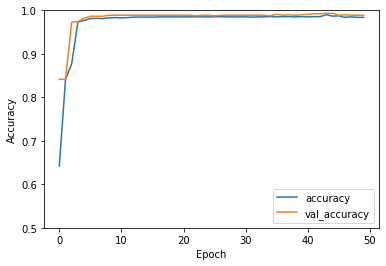

In [113]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(x_valid, y_valid, verbose=2)


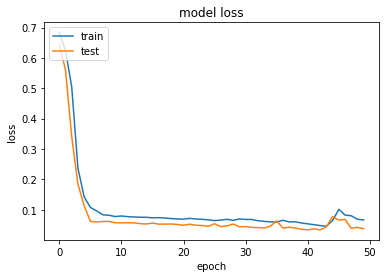

In [114]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

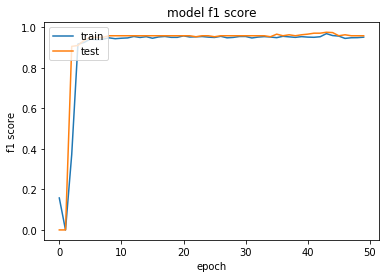

In [115]:
# summarize history for f1 score
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()